In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib import rcParams

### CONFIGURAÇÕES INICIAIS

In [23]:
# Configurações de estilo melhoradas
def configurar_ambiente():
    """Configura o ambiente visual para os gráficos e análises"""
    plt.style.use('seaborn-v0_8')
    rcParams.update({
        'font.family': 'DejaVu Sans',
        'figure.figsize': (12, 8),
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })
    sns.set_palette("husl")
    pd.set_option('display.max_columns', 100)
    pd.set_option('display.width', 1000)

configurar_ambiente()

### CARREGAMENTO E PREPARAÇÃO DOS DADOS

In [24]:
def corrigir_manual(texto):
    """Corrige caracteres especiais problemáticos"""
    if not isinstance(texto, str):
        return texto
    
    substituicoes = {
        '�': 'ç', '�': 'ã', '�': 'á', '�': 'ê',
        '�': 'õ', '�': 'ô', '�': 'é', '�': 'ó',
        '�': 'í', '�': 'ú', '�': 'â', '�': ' ', '�': '-'
    }
    
    for char_errado, char_certo in substituicoes.items():
        texto = texto.replace(char_errado, char_certo)
    return texto

def carregar_dicionario():
    """Carrega e prepara o dicionário de variáveis"""
    try:
        dic = pd.read_csv('../../Bases/Originais/PNS_titulos.csv', 
                         sep=';',
                         encoding='latin1')
        
        # Criar mapeamentos
        nome_por_codigo = dict(zip(dic.iloc[:, 0], dic.iloc[:, 1]))
        dic.iloc[:, 1] = dic.iloc[:, 1].apply(corrigir_manual)
        dicionario_corrigido = dict(zip(dic.iloc[:, 0], dic.iloc[:, 1]))
        
        return nome_por_codigo, dicionario_corrigido
    except Exception as e:
        print(f"Erro ao carregar dicionário: {e}")
        return {}, {}

def carregar_dados():
    """Carrega os dados principais da pesquisa"""
    try:
        df = pd.read_csv('../../Bases/Criados/base_doencas_cardiacas.csv', 
                        encoding='utf-8')
        nome_por_codigo, _ = carregar_dicionario()
        return df, nome_por_codigo
    except Exception as e:
        print(f"Erro ao carregar dados: {str(e)}")
        exit()

# Carregar os dados
df, nome_por_codigo = carregar_dados()

### IDENTIFICAÇÃO DE DADOS FALTANTES

In [25]:
def analisar_faltantes(df):
    """Realiza análise completa de dados faltantes"""
    dados_faltantes = df.isnull().sum()
    colunas_com_faltantes = dados_faltantes[dados_faltantes > 0].sort_values(ascending=False)
    
    return {
        'colunas_com_faltantes': colunas_com_faltantes,
        'colunas_sem_faltantes': [col for col in df.columns if col not in colunas_com_faltantes],
        'total_faltantes': dados_faltantes.sum(),
        'percentual_total': (dados_faltantes.sum() / (len(df) * len(df.columns)) * 100)
    }

# Executar análise
analise = analisar_faltantes(df)

### FUNÇÃO PARA GRÁFICOS RELATIVOS (100% STACKED)

<Figure size 1400x800 with 0 Axes>

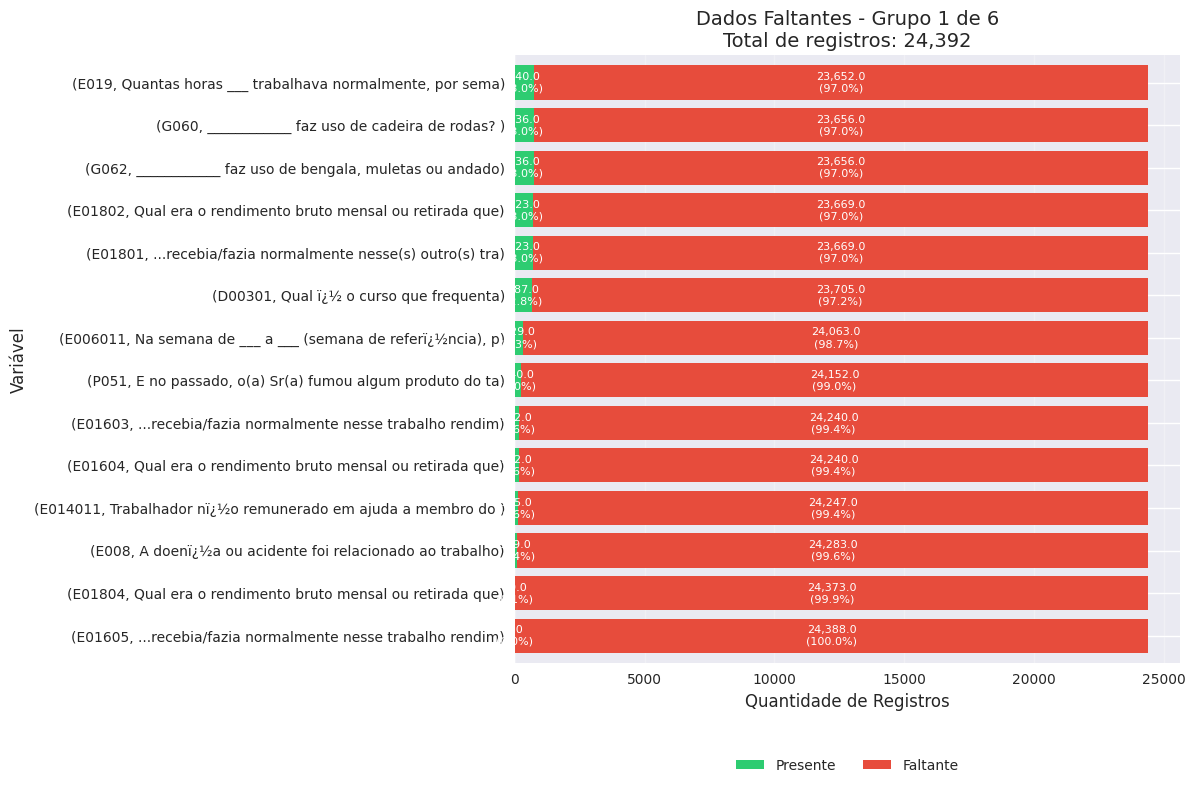

<Figure size 1400x800 with 0 Axes>

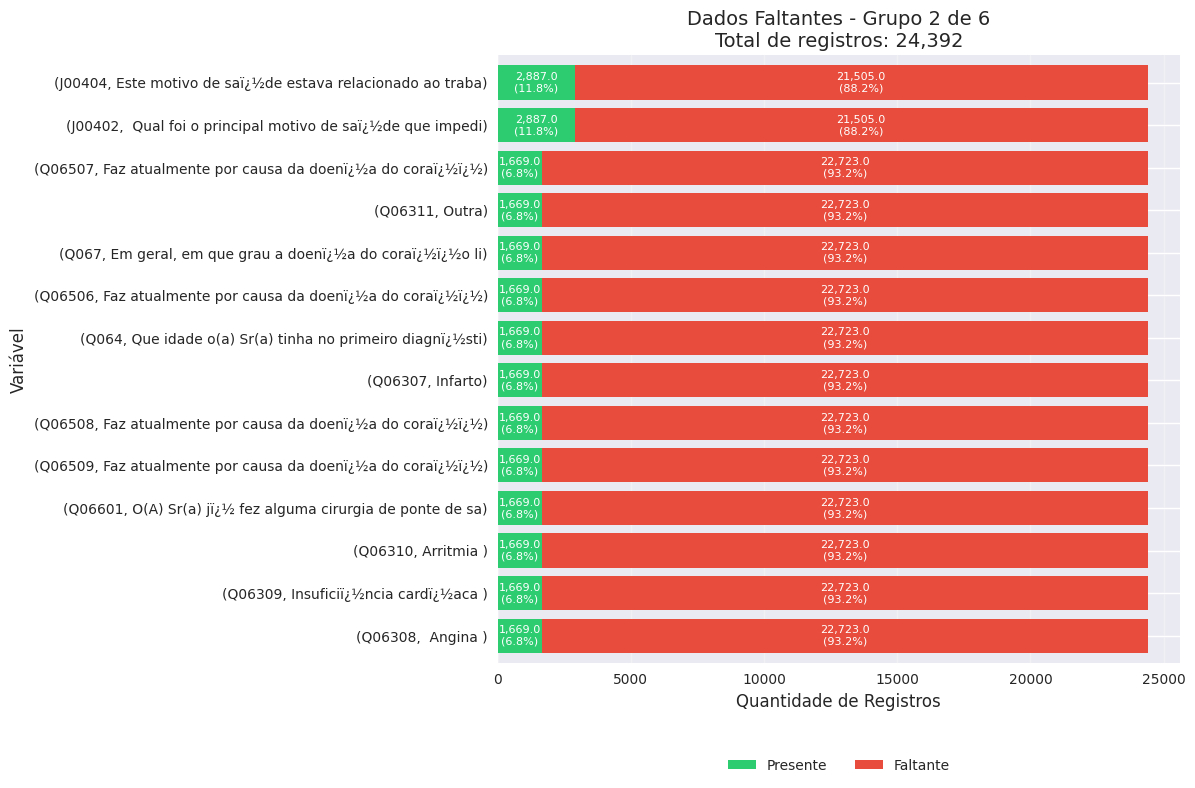

<Figure size 1400x800 with 0 Axes>

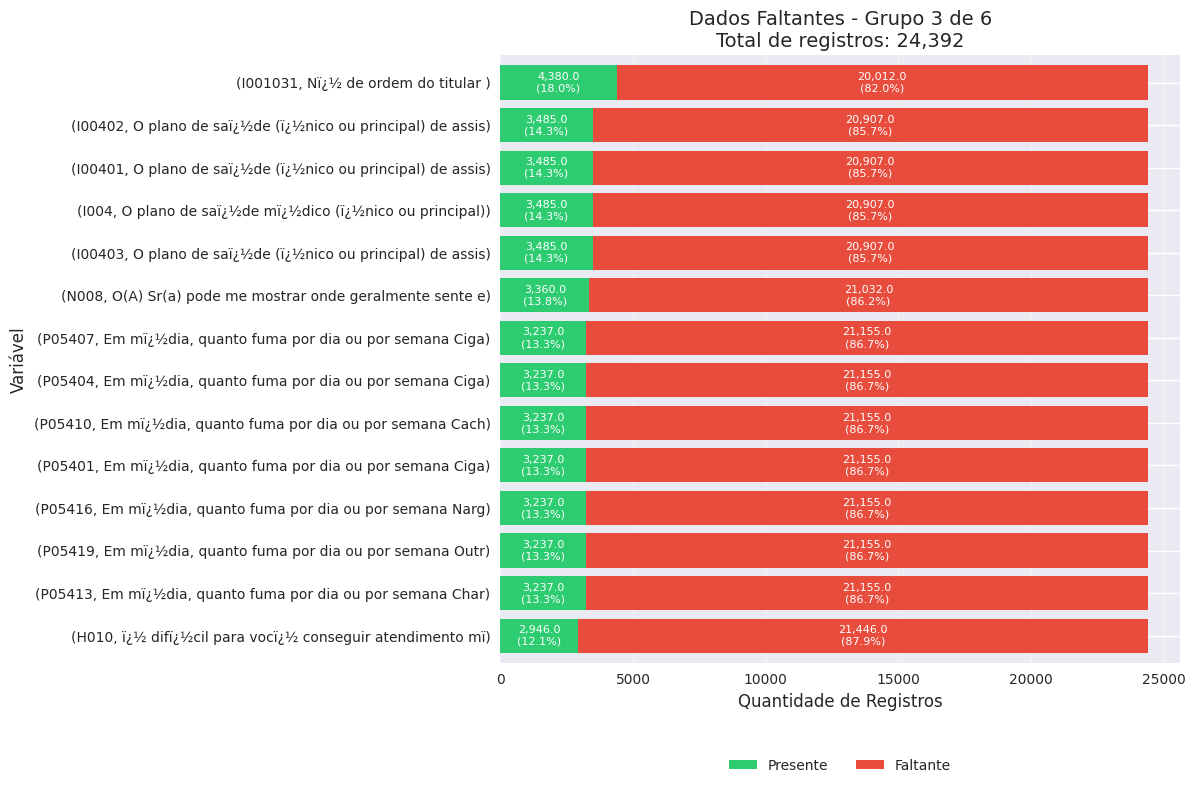

<Figure size 1400x800 with 0 Axes>

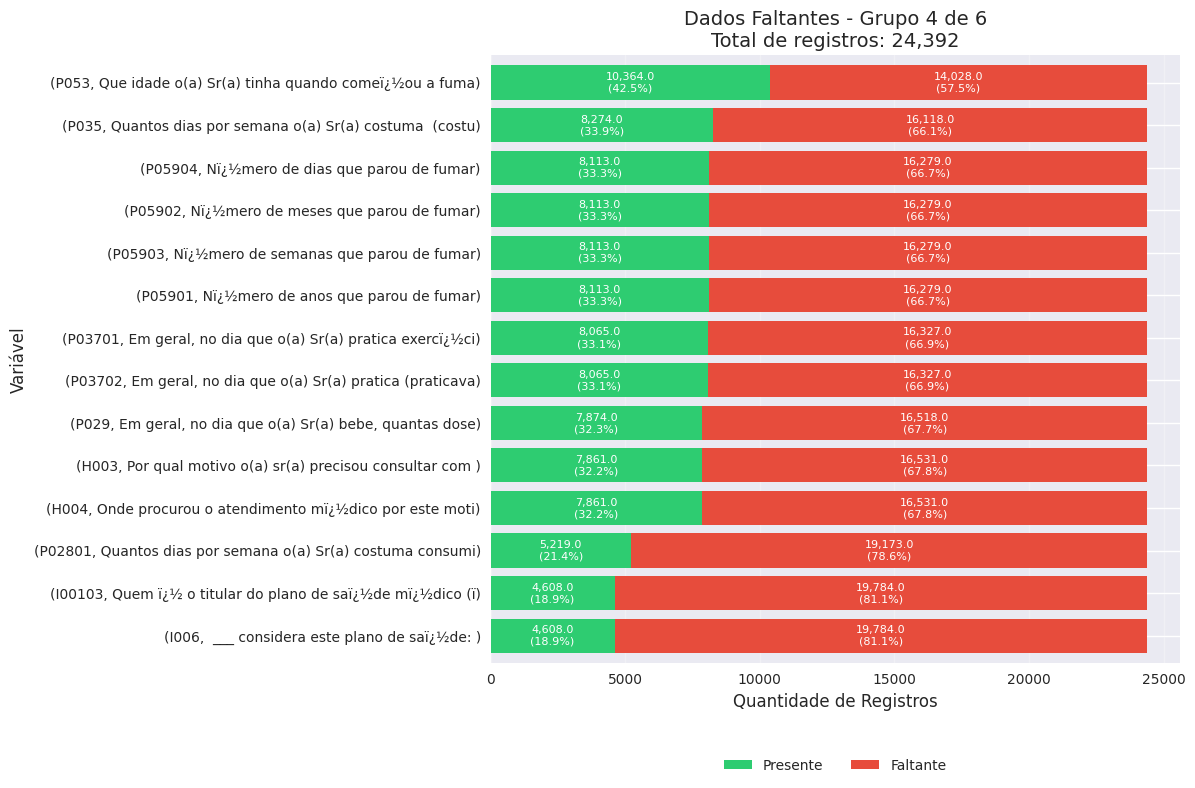

<Figure size 1400x800 with 0 Axes>

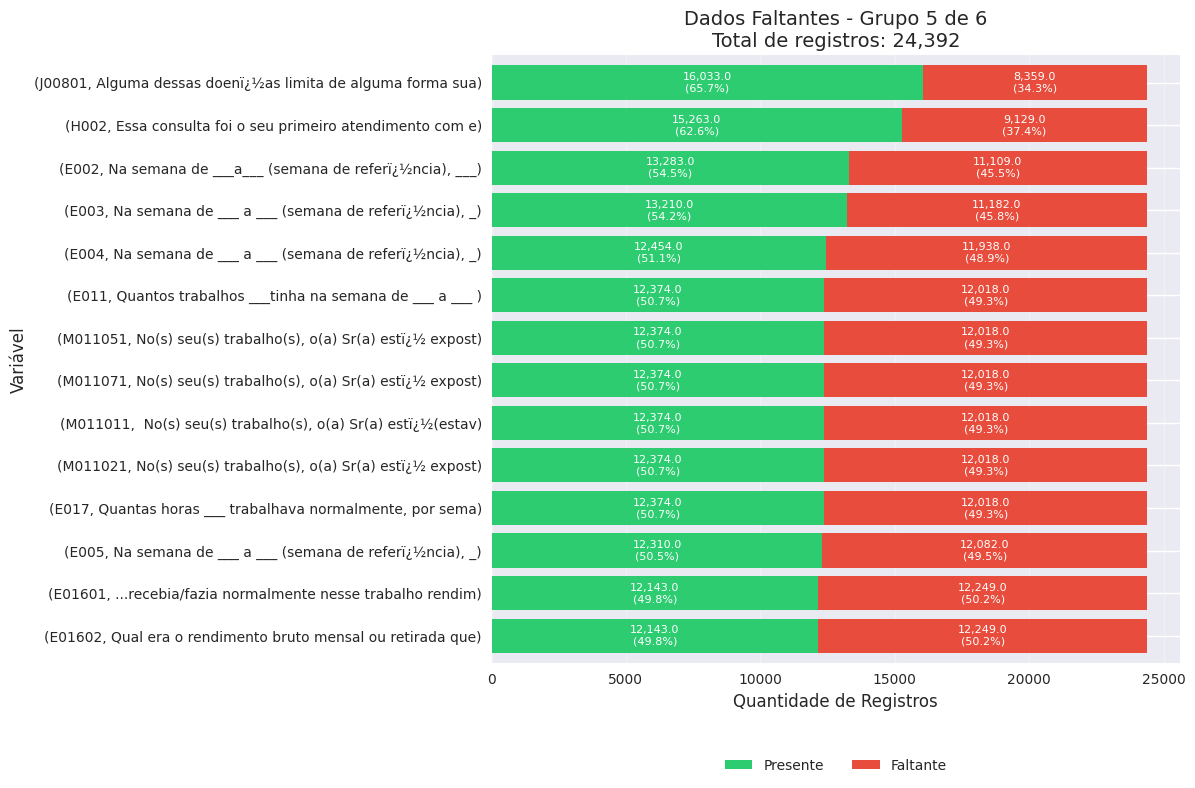

<Figure size 1400x800 with 0 Axes>

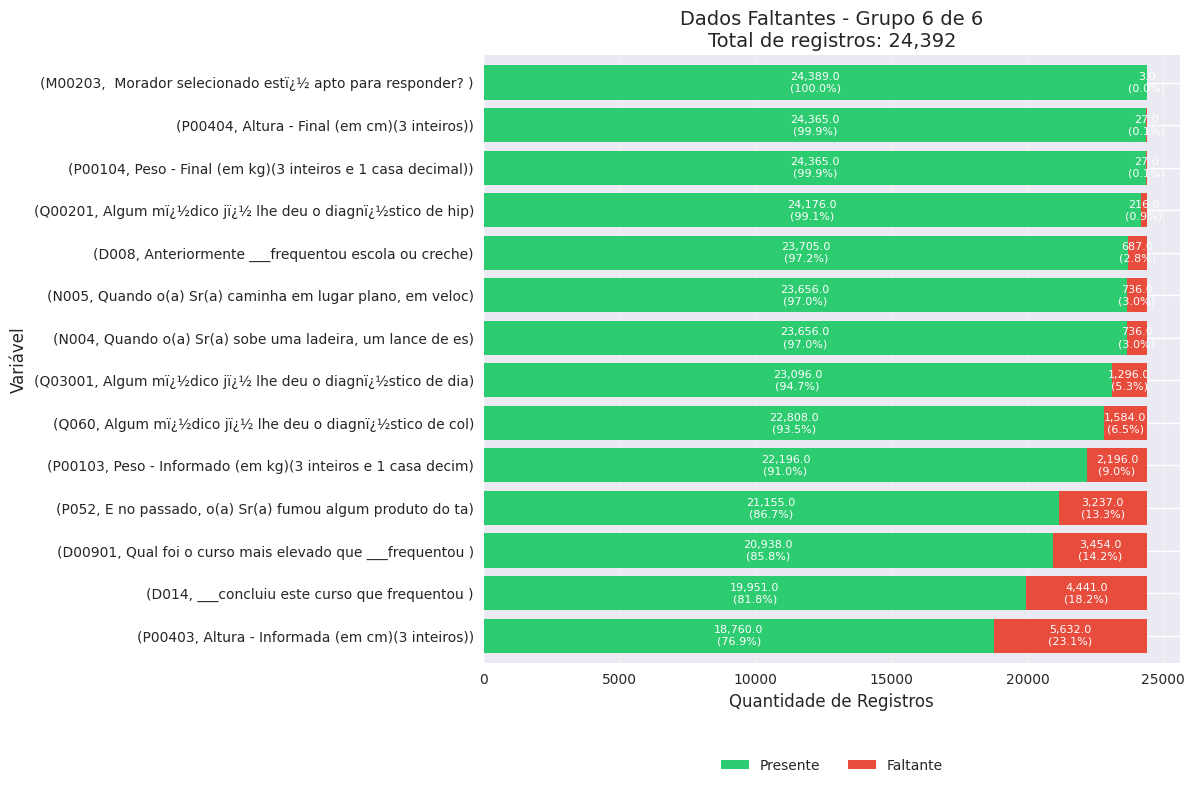

In [26]:
def plotar_faltantes(df, colunas_com_faltantes, nome_por_codigo, save_dir='Imagens'):
    """Gera e salva gráficos de dados faltantes"""
    os.makedirs(save_dir, exist_ok=True)
    grupos = np.array_split(colunas_com_faltantes.index, np.ceil(len(colunas_com_faltantes)/15))
    
    for i, grupo in enumerate(grupos, 1):
        plt.figure(figsize=(14, 8))
        
        dados_plot = pd.DataFrame({
            'Coluna': grupo,
            'Presente': [len(df) - df[col].isna().sum() for col in grupo],
            'Faltante': [df[col].isna().sum() for col in grupo],
            'Descricao': [corrigir_manual(nome_por_codigo.get(col, col))[:50] for col in grupo]
        })
        
        ax = dados_plot.set_index(['Coluna', 'Descricao']).plot(
            kind='barh', 
            stacked=True,
            color=['#2ecc71', '#e74c3c'],
            width=0.8
        )
        
        # Adicionar rótulos
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                ax.annotate(f"{width:,}\n({width/len(df)*100:.1f}%)",
                           (p.get_x() + width/2, p.get_y() + p.get_height()/2),
                           ha='center', va='center', color='white', fontsize=8)
        
        # Configurações do gráfico
        plt.title(f'Dados Faltantes - Grupo {i} de {len(grupos)}\nTotal de registros: {len(df):,}')
        plt.xlabel('Quantidade de Registros')
        plt.ylabel('Variável')
        plt.legend(['Presente', 'Faltante'], loc='lower center', 
                  bbox_to_anchor=(0.5, -0.2), ncol=2)
        plt.grid(True, axis='x', alpha=0.3)
        plt.tight_layout()
        
        plt.savefig(f'{save_dir}/dados_faltantes_grupo_{i}.png', dpi=300, bbox_inches='tight')
        plt.show()

# Gerar gráficos
plotar_faltantes(df, analise['colunas_com_faltantes'], nome_por_codigo)

### ANÁLISE DE DADOS FALTANTES

In [27]:
def gerar_relatorio(analise, nome_por_codigo, filename='relatorio_dados_faltantes.txt'):
    """Gera relatório completo em arquivo texto"""
    with open(filename, 'w', encoding='utf-8') as f:
        # Cabeçalho
        f.write("RELATÓRIO DE DADOS FALTANTES\n")
        f.write("="*60 + "\n\n")
        
        # Estatísticas gerais
        f.write("ESTATÍSTICAS GERAIS:\n")
        f.write("-"*60 + "\n")
        f.write(f"Total de variáveis analisadas: {len(df.columns)}\n")
        f.write(f"Variáveis sem dados faltantes: {len(analise['colunas_sem_faltantes'])}\n")
        f.write(f"Variáveis com dados faltantes: {len(analise['colunas_com_faltantes'])}\n")
        f.write(f"Total de valores faltantes: {analise['total_faltantes']:,}\n")
        f.write(f"Percentual total de dados faltantes: {analise['percentual_total']:.2f}%\n\n")
        
        # Variáveis sem faltantes
        f.write("VARIÁVEIS SEM DADOS FALTANTES:\n")
        f.write("-"*60 + "\n")
        for col in analise['colunas_sem_faltantes']:
            f.write(f"{col} - {nome_por_codigo.get(col, 'Descrição não disponível')}\n")
        
        # Variáveis com faltantes (detalhado)
        f.write("\n\nVARIÁVEIS COM DADOS FALTANTES (ORDENADAS POR QUANTIDADE):\n")
        f.write("-"*90 + "\n")
        f.write(f"{'Variável':<15} {'Descrição':<50} {'Faltantes':>10} {'% Faltantes':>12}\n")
        f.write("-"*90 + "\n")
        
        for col, qtd in analise['colunas_com_faltantes'].items():
            desc = nome_por_codigo.get(col, 'Descrição não disponível')
            percent = (qtd / len(df)) * 100
            f.write(f"{col:<15} {desc[:50]:<50} {qtd:>10,} {percent:>10.2f}%\n")

# Gerar relatório
gerar_relatorio(analise, nome_por_codigo)
print("Relatório salvo em 'relatorio_dados_faltantes.txt'")
print("\nAnálise concluída com sucesso!")

Relatório salvo em 'relatorio_dados_faltantes.txt'

Análise concluída com sucesso!
